In [2]:
%pylab inline

import dipy.reconst.dti as dti
import numpy as np
import nibabel as nib
import time
import seaborn as sns

from experimento1_funciones import *
from utils.DataGetter import DataGetter
from utils.DownsampledImage import DownsampledImage
from utils.DmriSampleCreators import LrHrDmriRandomSampleCreator
from utils.dmri_patch_operations.LrHrPatchIterator import LrHrPatchIterator
from utils.dmri_patch_operations.DtiModel import DtiModel

from utils.ml.MLDataBuilder import SimpleDtiMlDataBuilder
from utils.persistance.MLPersistence import MLPersistence

from sklearn import linear_model


Populating the interactive namespace from numpy and matplotlib


/user/lgomez/home/anaconda2/lib/python2.7/site-packages/skimage/filter/__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '


In [4]:
from utils.img_utils import _is, _isc, padding, column_this, _is3d
from utils.math_utils import mse, nmse, normalize, normalize_by_bval, coef_det_4thdim, coef_det

Empiezo el experimento
---

Defino los parametros de patch n y m. Y cargo las imagenes de entrenamiento

In [5]:
name_experiment='experimento1'
n, m = 2, 2
n_samples = 559

X, Y, lr_hr_imgs = load_dmri(n_samples, n, m)

Dataset is already in place. If you want to fetch it again please first remove the folder /user/lgomez/home/.dipy/stanford_hardi 
Dataset is already in place. If you want to fetch it again please first remove the folder /user/lgomez/home/.dipy/stanford_hardi 
[('standfor_hardi', (81, 106, 76, 160))]
Samples for  standfor_hardi : 559 of 560
X: (750, 559) Y: (48, 559)


In [6]:
## Para no entrenar cada vez
# regr = MLPersistence.load(name_experiment)
regr = None
if regr is None or True:
    ## Entreno con todas las samples menos la ultima que la uso para test
    regr, dmri_X_train , dmri_y_train, dmri_X_test, dmri_y_test = train(X,Y)

    ## Guardo en archivo
    MLPersistence.save(regr, name_experiment)

    ### Impresion de variables del fiteo
    ## The mean square error
    print("Residual sum of squares: %.2f" % np.mean((regr.predict(dmri_X_test) - dmri_y_test) ** 2))
    ## Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % regr.score(dmri_X_test, dmri_y_test))

Training set_training.shape= (750, 558)  ->target.shape= (48, 558)
Residual sum of squares: 0.00
Variance score: 0.00


('Imagen a predecir:', (45, 57, 42, 160))

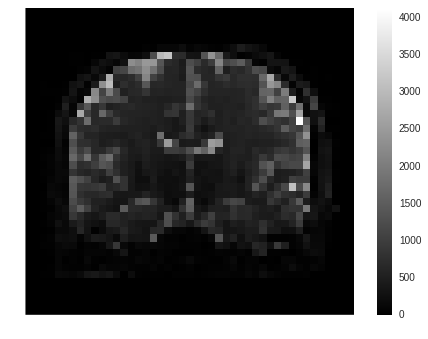

In [7]:
## Tomo una imagen para reconstruir
img_a_reconstruir = lr_hr_imgs[0];

## Hacerle el pading
img_lr = padding(img_a_reconstruir.get_lr_img(), 2)

_is(img_lr)
('Imagen a predecir:', img_lr.shape)

In [8]:
## Shape de las imagenes
img_hr_shape = img_a_reconstruir.get_hr_img().shape
img_lr_shape = img_lr.shape

## Armo el esqueleto de la dti-imagen
sx, sy, sz, _ = img_lr_shape
dti_img_hr = np.zeros((sx*m, sy*m, sz*m, 6), dtype='float');

## Creo un iterador sobre la imagen lr
it = LrHrPatchIterator(img_lr_shape, n, m)

## Trabajamos con la representacion dti
img_hr_gtab = img_a_reconstruir.get_gtab();
dti_model = DtiModel(img_hr_gtab);
img_lr_dti = dti_model._fit_model(img_lr)

'img_lr_dti : ', img_lr_dti.shape

('img_lr_dti : ', (45, 57, 42, 6))

In [17]:
# Gradientes elegidos arbirtraiamente con bval nulo y no nulo respectivamente
bnull=0
bnotnul=15
img_hr_gtab.bvecs[bnull],img_hr_gtab.bvecs[bnotnul] 
#img_hr_gtab.bvecs


(array([ 0.,  0.,  0.]), array([ 0.15103,  0.96523,  0.21336]))

PREDICCION
---
Ahora por cada patch de la imagen en baja resoluci'on a reconstruir (en su versi'on DTI), calculo los valores dti del pixel del centro en la imagen. Dicho pixel del centro en la imagen de baja resoluci'on se convierten en 8 pixeles en la imagen de alta resoluci'on equivalente.


In [18]:
sum=0;
start_time = time.time()
for data_ranges_lr_hr in it :
    sum=sum+1;

    # Indices en la imagen lr
    x0, xf, y0, yf, z0, zf = data_ranges_lr_hr['lr']

    # Fiteo el modelo del patch-lr (6 params dti)
    dti_patch_vol = img_lr_dti[x0:xf, y0:yf, z0:zf]

    x_vol = dti_patch_vol #dti_model.get_dti_params(dti_patch_vol)

    # Lo estructuro para que lo entienda ML (5,5,5,6) --> (1x750)
    x = column_this(x_vol)
    y = regr.predict(x.T)
    # Lo reestructuro (1,48) --> (2,2,2,6)
    dti_vol = y.reshape((2, 2, 2, 6))

    # Indices equivalentes en la imagen hr
    (a0, af, b0, bf, c0, cf) = data_ranges_lr_hr['hr']
    dti_img_hr[a0:af, b0:bf, c0:cf, :] = dti_vol

seg = time.time() - start_time
min = int(seg / 60)
print("--- time of predictions patchs : %d' %d'' --- num. iterations: %d" % (min , seg%60, sum))

--- time of predictions patchs : 0' 6'' --- num. iterations: 82574


In [19]:
del dmri_X_train
del dmri_y_train
del dmri_X_test
del dmri_y_test
del it
del regr
del dti_model
del img_lr_dti
#del dti_model

El resultado de la prediccion
---

In [20]:
## La corto porque tenia dimensiones de longitud impares
dti_img_hr = dti_img_hr[0:81,0:106,0:76, :]
'dti_img_hr=', dti_img_hr.shape

('dti_img_hr=', (81, 106, 76, 6))

In [21]:
## Calculo la repreesentacion dti de la original para comparar
orig_dwi = lr_hr_imgs[0].get_hr_img()
tenmodel = dti.TensorModel(img_hr_gtab)
tenfit = tenmodel.fit(orig_dwi, mask=orig_dwi[..., 0] > 200)
## Paso a version con los 6 params dti en cada voxel (original devuelve el objeto Tensor de dipy)
orig_dti = tenfit.lower_triangular()

In [54]:
## Calculo ecm de todos los voxels por parametro dti 
#ecm_dti = mse_by_bval(dti_img_hr, orig_dti)
ecm_dti = np.array([mse(dti_img_hr[:,:,:,dtiparam], orig_dti[:,:,:,dtiparam]) for dtiparam in range(0,6)])
ecm_dti.shape


(6,)

([<matplotlib.axis.XTick at 0x7f9bfda37050>,
 <a list of 6 Text xticklabel objects>)

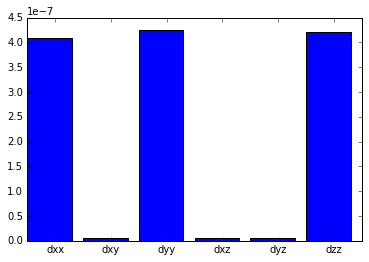

In [55]:
## Dibujo el ecm como grafico de barras
# print np.linalg.norm(dti_img_hr-orig_dti)
plt.bar(range(0,ecm_dti.size), ecm_dti)
plt.xticks(arange(ecm_dti.size)+0.5,('dxx','dxy','dyy','dxz','dyz','dzz'))

(81, 106, 76, 6) (81, 106, 76, 6)
(6,)


([<matplotlib.axis.XTick at 0x7f44e5ed2390>,
 <a list of 6 Text xticklabel objects>)

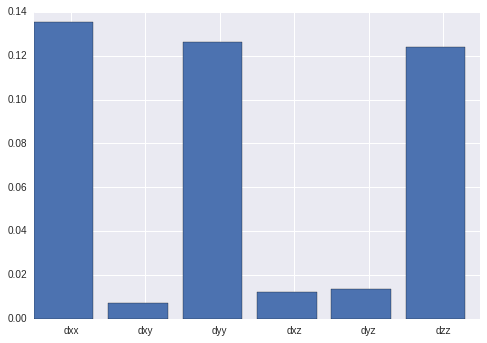

In [33]:
cdet_dti = coef_det_4thdim(dti_img_hr,orig_dti)
## Dibujo el coef det como grafico de barras
# print np.linalg.norm(dti_img_hr-orig_dti)
plt.bar(range(0,cdet_dti.size), cdet_dti)
plt.xticks(arange(cdet_dti.size)+0.5,('dxx','dxy','dyy','dxz','dyz','dzz'))

In [15]:
del ecm_dti
del cdet_dti

In [34]:
cdet_dti_by_voxel = coef_det(dti_img_hr, orig_dti,3)
#necm_dti_by_voxel = nmse(dti_img_hr, orig_dti,3)
#ecm_dti_by_voxel = mse(dti_img_hr, orig_dti,3)
#ecm_dti_by_voxel.shape, cdet_dti_by_voxel.shape

cant de nan= 83675


('mse de todo el volumne', 0.98910038335089312, nan)

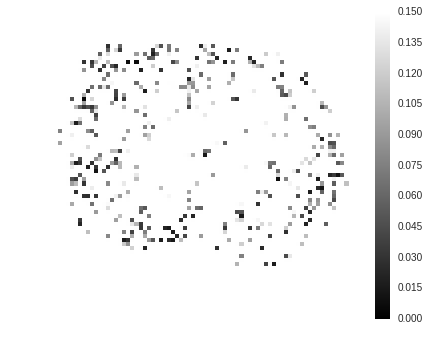

In [36]:

print 'cant de nan=', np.sum(np.isnan(cdet_dti_by_voxel))
#print cdet_dti_by_voxel.shape
#print cdet_dti_by_voxel[(~np.isnan(cdet_dti_by_voxel))].shape
plt = _is(cdet_dti_by_voxel)
plt.clim(0.0, 0.15)
'mse de todo el volumne', coef_det(dti_img_hr, orig_dti), cdet_dti_by_voxel.max() 

('mse de todo el volumne', 2.1194067927857959e-07)

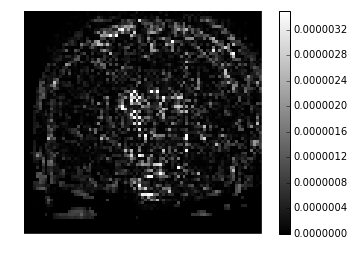

In [30]:
plt = _is(ecm_dti_by_voxel)
plt.clim(0,0.0000035)
'mse de todo el volumne', mse(dti_img_hr, orig_dti)

/home/lgomez/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in divide
/home/lgomez/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in divide


nan

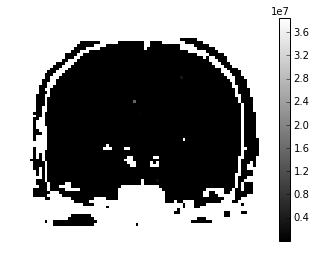

In [42]:
_is(necm_dti_by_voxel)
'normalized mse de todo el volumne', nmse(dti_img_hr, orig_dti)

In [46]:
del necm_dti_by_voxel 
del ecm_dti_by_voxel

In [ ]:
# Dibujo ecm como imagen
dxx=0
_isc(dti_img_hr,orig_dti,2, dxx)


# RECONSTRUCCION

### DTI --> DW-MRI (1)

Reconstruyo usando dipy

In [37]:
start_time = time.time()

st = time.time()
## Agarrar el fiteo y pasarlo a imagen
tenmodel = dti.TensorModel(img_a_reconstruir.get_gtab())
#tensors = dti.from_lower_triangular(dti_img_hr)
# (12 dti params --eval--evecs--)
tensors = dti.eig_from_lo_tri(dti_img_hr.astype(float))
img_reconstructed = tenmodel.predict(tensors)

seg = time.time() - st
min = int(seg / 60)
print("--- time of METHOD #01 : %d' %d'' --- " % (min , seg%60))

--- time of METHOD #01 : 0' 9'' --- 


#### HISTOGRAMA

(array([      0.,       0.,       0.,       0.,       0.,  652536.,
              0.,       0.,       0.,       0.]),
 array([ 0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,  1.2,  1.3,  1.4,  1.5]),
 <a list of 10 Patch objects>)

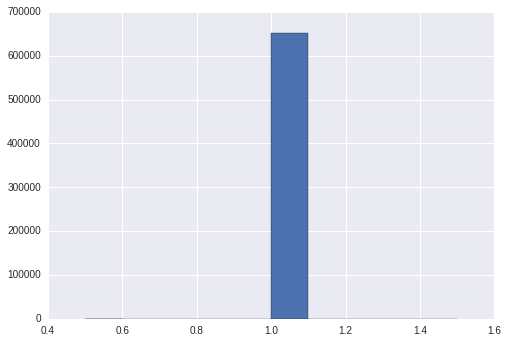

In [44]:
## Histograma con gradiente al azar nulo
plt.hist(img_reconstructed[:,:,:,bnull].reshape(-1))
#plt.xlim(1.0,1.2)
#plt.xlim(0.4,0.8)

(array([  77684.,   57772.,   41535.,   27755.,   20187.,   17031.,
          15792.,   16320.,   19613.,  358847.]),
 array([  4.80726848e-05,   1.00043265e-01,   2.00038458e-01,
          3.00033651e-01,   4.00028844e-01,   5.00024036e-01,
          6.00019229e-01,   7.00014422e-01,   8.00009615e-01,
          9.00004807e-01,   1.00000000e+00]),
 <a list of 10 Patch objects>)

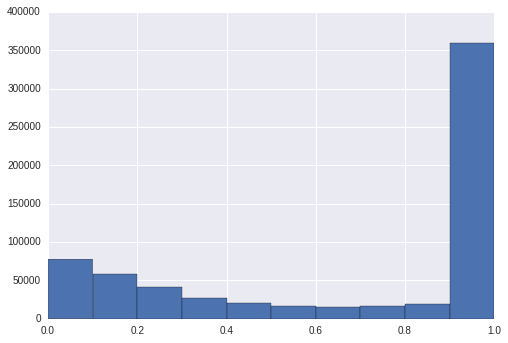

In [45]:
## Histograma con gradiente al azar no nulo
plt.hist(img_reconstructed[:,:,:,bnotnul].reshape(-1))

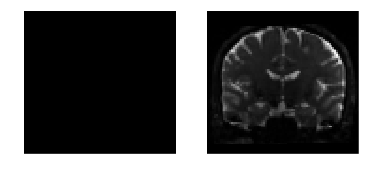

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

In [60]:
_isc(img_reconstructed, img_a_reconstruir.get_hr_img(), 2, bnull)

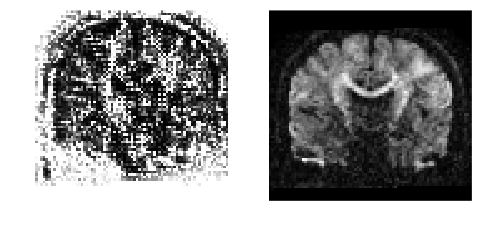

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

In [46]:
_isc(img_reconstructed, img_a_reconstruir.get_hr_img(), 2, bnotnul)

### ECM


In [47]:
## Unica vez
img_lr_orig_norm = normalize_by_bval(img_a_reconstruir.get_hr_img().astype(float))
print 'max:min (', np.min(img_lr_orig_norm), ':', np.max(img_lr_orig_norm), ')'

maximo valor antes de normalizar : 13321.0
max:min ( 0.0 : 1.0 )


In [49]:
img1norm = normalize_by_bval(img_reconstructed)
#means1 = np.array([mse(img1norm[:,:,:,i], img_lr_orig_norm[:,:,:,i])for i in range(0,21)])
#means1.shape
cdet1 = np.array([coef_det(img1norm[:,:,:,i], img_lr_orig_norm[:,:,:,i]) for i in range(0,21)])
cdet1.shape



maximo valor antes de normalizar : 1.0


(21,)

<Container object of 20 artists>

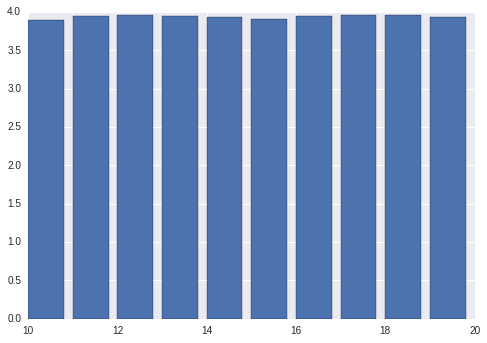

In [50]:
#plt.bar(arange(20), means1[0:20])
plt.bar(arange(20), cdet1[0:20])

In [51]:
del means1
#del cdet

### DTI --> DW-MRI (3)

Reconstruyo usando reconstruccion (1) multiplica la S0 original.

In [52]:
S0 = img_a_reconstruir.get_hr_img()[:,:,:,0]

st = time.time()

img_reconstructed3 = np.zeros((img_reconstructed.shape), dtype='float')
sx, sy, sz , _ = img_reconstructed.shape
for i in range(0, sx):
    for j in range(0, sy):
        for k in range(0, sz):
            img_reconstructed3[i,j,k,:] = S0[i][j][k] * img_reconstructed[i,j,k,:]

seg = time.time() - st
min = int(seg / 60)
print("--- time of dipy*S0 : %d' %d'' --- " % (min , seg%60))


--- time of dipy*S0 : 0' 3'' --- 


In [72]:
## Ahoras si no la uso mas
del img_reconstructed

max:min 0.0 -> 13157.0


(0, 6000)

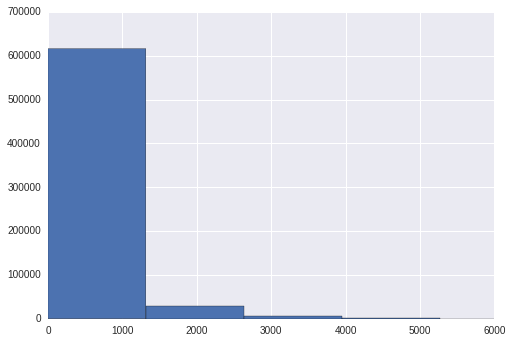

In [69]:
## Histograma con gradiente al azar nulo
print 'max:min', np.min(img_reconstructed3),'->', np.max(img_reconstructed3)
plt.hist(img_reconstructed3[:,:,:,bnull].reshape(-1))
plt.xlim(0,6000)
#plt.xticks(np.arange(0.0,6000, 100))


(array([  6.44678000e+05,   6.26500000e+03,   1.06300000e+03,
          3.56000000e+02,   9.80000000e+01,   3.70000000e+01,
          1.90000000e+01,   1.40000000e+01,   5.00000000e+00,
          1.00000000e+00]),
 array([     0. ,   1315.7,   2631.4,   3947.1,   5262.8,   6578.5,
          7894.2,   9209.9,  10525.6,  11841.3,  13157. ]),
 <a list of 10 Patch objects>)

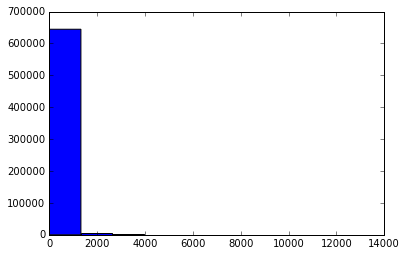

In [76]:
## Histograma con gradiente al azar no nulo
hist(img_reconstructed3[:,:,:,bnotnul].reshape(-1))

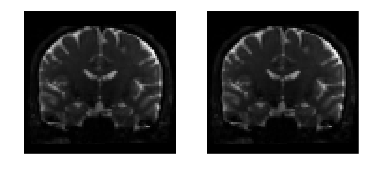

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

In [77]:
_isc(img_reconstructed3, img_a_reconstruir.get_hr_img(), 2, bnull)

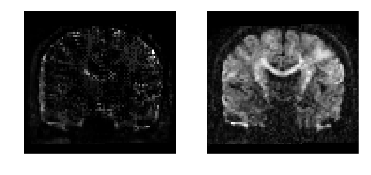

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

In [78]:
_isc(img_reconstructed3, img_a_reconstruir.get_hr_img(), 2, bnotnul)

### ECM


In [80]:
img3norm = normalize_by_bval(img_reconstructed3)
means3 = np.array([mse(img3norm[:,:,:,i], img_lr_orig_norm[:,:,:,i]) for i in range(0,21)])
means3.shape

maximo valor antes de normalizar : 13157.0


(21,)

<Container object of 20 artists>

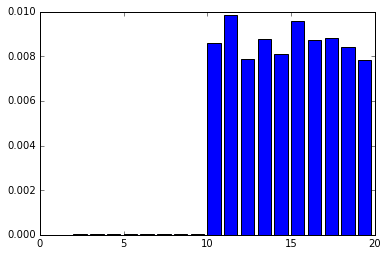

In [81]:
plt.bar(arange(20), means3[0:20])

In [83]:
del img_reconstructed3
del means3

#### DTI --> DW-MRI (2)

Reconstruyo usando reconstruccion hecha por mi (multiplica la S0 original)

In [84]:
from utils.Dti2Dwi import Dti2Dwi

st = time.time()

dti2dwi = Dti2Dwi(dti_img_hr)
# S0 origina
S0 = img_a_reconstruir.get_hr_img()[:,:,:,0]
img_reconstructed2 = dti2dwi.predict(img_a_reconstruir.get_gtab(), S0)

seg = time.time() - st
min = int(seg / 60)
print("--- time of craft dti : %d' %d'' --- " % (min , seg%60))


utils/Dti2Dwi.py:75: RuntimeWarning: overflow encountered in exp
  dwi[i][j][k][z] = np.exp((-1)*np.dot(BD[z], B[z])) * S0[i][j][k]
utils/Dti2Dwi.py:75: RuntimeWarning: overflow encountered in double_scalars
  dwi[i][j][k][z] = np.exp((-1)*np.dot(BD[z], B[z])) * S0[i][j][k]
utils/Dti2Dwi.py:75: RuntimeWarning: invalid value encountered in double_scalars
  dwi[i][j][k][z] = np.exp((-1)*np.dot(BD[z], B[z])) * S0[i][j][k]


--- time of craft dti : 9' 26'' --- 


In [89]:
print_info(img_reconstructed2[:,:,:,15], 'img_reconstructed2')

img_reconstructed2 : (min:max) 0.0 : 1.79632575951e+308 ptp: 1.79632575951e+308
#inf:  0 #-inf:  0  #Nan:  0
#uniques= 106647
histograma:
    #voxels:  [616041     38     21      9      9      6      5      4      3  36400]
    valor:  [  0.00000000e+000   1.79632576e+307   3.59265152e+307   5.38897728e+307
   7.18530304e+307   8.98162880e+307   1.07779546e+308   1.25742803e+308
   1.43706061e+308   1.61669318e+308   1.79632576e+308]
dtype float64



(array([  6.16038000e+05,   2.81770000e+04,   6.31400000e+03,
          1.58000000e+03,   2.65000000e+02,   9.60000000e+01,
          3.70000000e+01,   1.90000000e+01,   9.00000000e+00,
          1.00000000e+00]),
 array([     0. ,   1315.7,   2631.4,   3947.1,   5262.8,   6578.5,
          7894.2,   9209.9,  10525.6,  11841.3,  13157. ]),
 <a list of 10 Patch objects>)

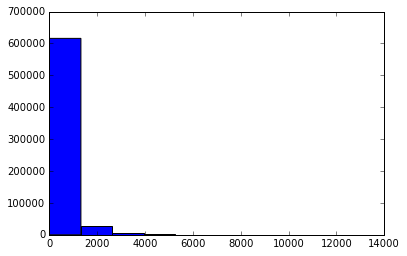

In [85]:
## Histograma con gradiente al azar nulo
hist(img_reconstructed2[:,:,:,bnull].reshape(-1))

OverflowError: cannot convert float infinity to integer

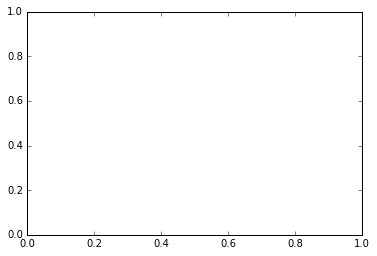

In [90]:
## Histograma con gradiente al azar nulo
hist(img_reconstructed2[:,:,:,15].reshape(-1))

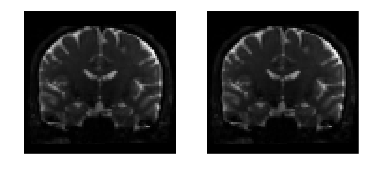

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

In [91]:
_isc(img_reconstructed2, img_a_reconstruir.get_hr_img(), 2, bnull)

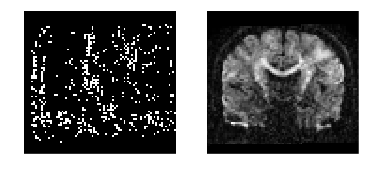

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

In [92]:
_isc(img_reconstructed2, img_a_reconstruir.get_hr_img(), 2, bnotnul)

#### ECM

In [93]:
img2norm = normalize_by_bval(img_reconstructed2)
means2 = np.array([mse(img2norm[:,:,:,i], img_lr_orig_norm[:,:,:,i]) for i in range(0,21)])
means2.shape

maximo valor antes de normalizar : 1.79632575951e+308


(21,)

<Container object of 20 artists>

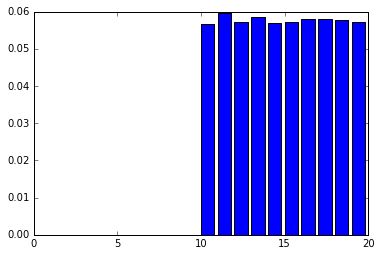

In [94]:
plt.bar(arange(20), means2[0:20])

In [ ]:
del img_reconstructed2
del means2

### DTI --> DW-MRI (4)


Reconstruyo usando de dipy pasandole la S0 original.

In [96]:
st = time.time()

img_reconstructed4 = tenmodel.predict(tensors, S0)

seg = time.time() - st
min = int(seg / 60)
print("--- time of dipy*S0 : %d' %d'' --- " % (min , seg%60))


/user/lgomez/home/anaconda2/lib/python2.7/site-packages/dipy/reconst/dti.py:1759: RuntimeWarning: divide by zero encountered in log
  D[..., 6] = -np.log(b0)


--- time of dipy*S0 : 0' 8'' --- 


(array([  6.16038000e+05,   2.81770000e+04,   6.31400000e+03,
          1.58000000e+03,   2.65000000e+02,   9.60000000e+01,
          3.70000000e+01,   1.90000000e+01,   9.00000000e+00,
          1.00000000e+00]),
 array([     0.        ,   1315.6994351 ,   2631.3988702 ,   3947.09830529,
          5262.79774039,   6578.49717549,   7894.19661059,   9209.89604568,
         10525.59548078,  11841.29491588,  13156.99435098]),
 <a list of 10 Patch objects>)

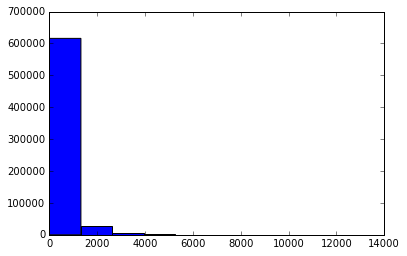

In [97]:
## Histograma con gradiente al azar nulo
hist(img_reconstructed4[:,:,:,bnull].reshape(-1))

(array([  6.44678000e+05,   6.26500000e+03,   1.06300000e+03,
          3.56000000e+02,   9.80000000e+01,   3.70000000e+01,
          1.90000000e+01,   1.40000000e+01,   5.00000000e+00,
          1.00000000e+00]),
 array([     0.        ,   1315.6994351 ,   2631.3988702 ,   3947.09830529,
          5262.79774039,   6578.49717549,   7894.19661059,   9209.89604568,
         10525.59548078,  11841.29491588,  13156.99435098]),
 <a list of 10 Patch objects>)

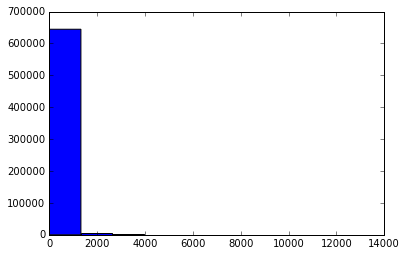

In [98]:
## Histograma con gradiente al azar nulo
hist(img_reconstructed4[:,:,:,bnotnul].reshape(-1))

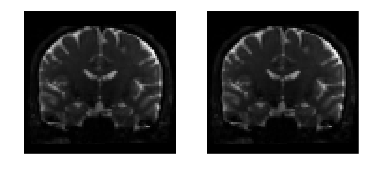

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

In [99]:
_isc(img_reconstructed4, img_a_reconstruir.get_hr_img(), 2, bnull)

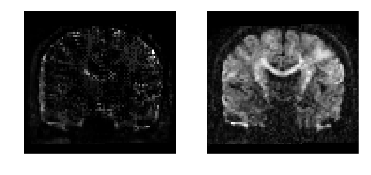

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

In [100]:
_isc(img_reconstructed4, img_a_reconstruir.get_hr_img(), 2, bnotnul)

#### ECM

In [101]:
img4norm = normalize_by_bval(img_reconstructed4)
means4 = np.array([mse(img4norm[:,:,:,i], img_lr_orig_norm[:,:,:,i]) for i in range(0,21)])
means4.shape

maximo valor antes de normalizar : 13156.994351


(21,)

<Container object of 20 artists>

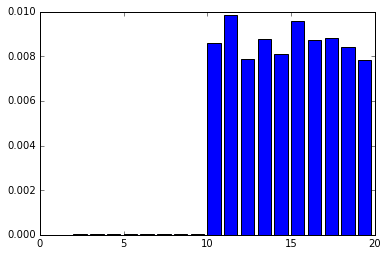

In [102]:
plt.bar(arange(20), means4[0:20])

In [ ]:
del img_reconstructed4
del means4